# Modelagem de séries temporais usando redes neurais recorrentes


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter # filtro para suavizar a série

In [2]:
# Leitura dos dados de COVID-19 do Brasil

pkgdir = 'Data'

df = pd.read_csv(f'{pkgdir}/owid-covid-data.csv', index_col='date', parse_dates=True)
df = df[df['location']=='Brazil']
population = df['population'][0]

# Seleciona apenas o número de casos e mortes diários
df = df[['new_cases','new_deaths']]

# Preenche os dados faltantes com interploção spline
df.interpolate('spline',order=2,inplace=True)

# filtragem da série usando o filtro Savitzky-Golay
df['new_cases'] = savgol_filter(df['new_cases'], 7, 2)
df['new_deaths'] = savgol_filter(df['new_deaths'], 7, 2)

#df2 = pd.DataFrame()
#window = 35
#df2['new_cases_f'] = pd.Series(df['new_cases']).rolling(window=window).mean().iloc[window-1:].values
#df2['new_deaths_f'] = pd.Series(df['new_deaths']).rolling(window=window).mean().iloc[window-1:].values
#df2.index = df.index[np.int((window-1)/2):-np.int((window-1)/2)]
#df = df2

df.columns = ['new_cases','new_deaths']
df = df[df.index>'2020-04-01']
#df = df[df.index<'2021-06-01']

idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(idx)
df.fillna(0,inplace=True)

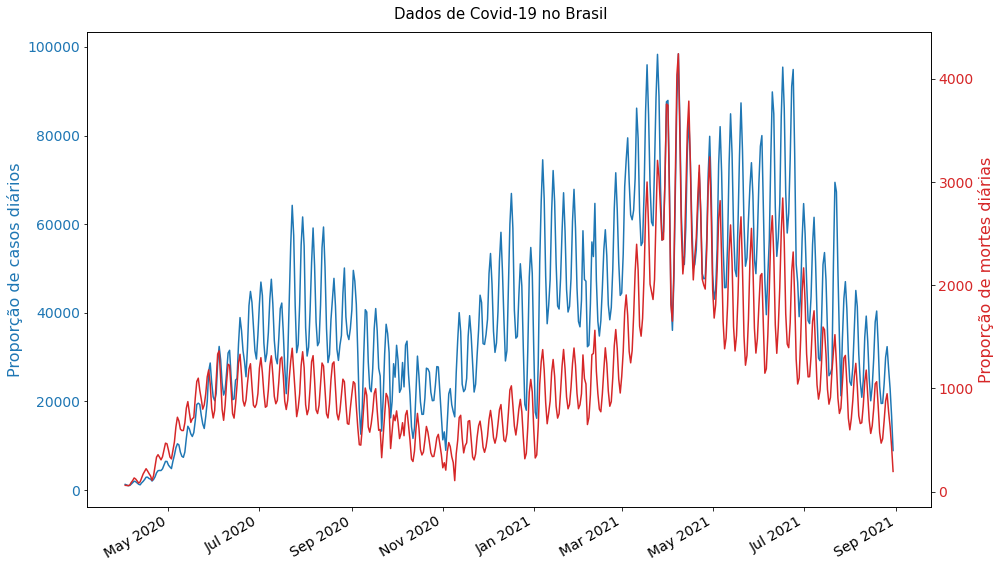

In [3]:
fig, ax1 = plt.subplots(figsize=(14,8))

color = 'tab:blue'
ax1.set_ylabel('Proporção de casos diários', color=color, fontsize=16)
ax1.plot(df['new_cases'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Proporção de mortes diárias', color=color, fontsize=16)  # we already handled the x-label with ax1
ax2.plot(df['new_deaths'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=14)
date_fmt = mdates.DateFormatter('%b %Y')
ax1.xaxis.set_major_formatter(date_fmt)
ax2.xaxis.set_major_formatter(date_fmt)
fig.suptitle("Dados de Covid-19 no Brasil",
             fontsize=15)
fig.autofmt_xdate()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Importante: Os dados precisam estar normalizados

In [4]:
# Normalização pela população vezes 10^3 e 10^4 para o número de casos e de mortes, respectivamente,
# para os valores não ficarem tão próximos a zero
df = [1000,10000]*df/population

## Divida a base em treino e teste

In [5]:
train = df.iloc[:-28]
test = df.iloc[-28:]

Y_train = train.to_numpy()
Y_test = test.to_numpy()

### Gerador de séries temporais


In [6]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [7]:
# Vamos redefinir lotes de tamanho 28 para o procedimento iterativo
# Veja mais informações sobre o tamanho do lote http://deeplearningbook.com.br/o-efeito-do-batch-size-no-treinamento-de-redes-neurais-artificiais/

n_input_cases = 28
n_input_deaths = 14
n_features = 1
generator_cases = TimeseriesGenerator(Y_train[:,[0]], Y_train[:,[1]], length=n_input_cases, batch_size=1)
generator_only_deaths = TimeseriesGenerator(Y_train[:,[1]], Y_train[:,[1]], length=n_input_deaths, batch_size=1)

### Definição do modelo usando Keras

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [9]:
# Modelo usando o número de casos como preditora
model_cases = Sequential()
model_cases.add(LSTM(56, activation='relu', unroll = True, input_shape=(n_input_cases, n_features)))
model_cases.add(Dense(1))
model_cases.compile(optimizer='adam', loss='mse')

In [10]:
model_cases.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 56)                12992     
_________________________________________________________________
dense (Dense)                (None, 1)                 57        
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Modelo usando o número de mortes
model_deaths = Sequential()
model_deaths.add(LSTM(56, activation='relu', unroll = True, input_shape=(n_input_deaths, n_features)))
model_deaths.add(Dense(1))
model_deaths.compile(optimizer='adam', loss='mse')

In [12]:
model_deaths.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 56)                12992     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 57        
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Ajuste do modelo com o número de casos diários

model_cases.fit(generator_cases,epochs=200)

Epoch 1/200
460/460 [==============================] - 5s 3ms/step - loss: 7.0373e-04
Epoch 2/200
460/460 [==============================] - 2s 3ms/step - loss: 5.3934e-04
Epoch 3/200
460/460 [==============================] - 1s 3ms/step - loss: 5.0203e-04
Epoch 4/200
460/460 [==============================] - 1s 3ms/step - loss: 5.2012e-04
Epoch 5/200
460/460 [==============================] - 1s 3ms/step - loss: 4.8157e-04
Epoch 6/200
460/460 [==============================] - 1s 3ms/step - loss: 4.4412e-04
Epoch 7/200
460/460 [==============================] - 1s 3ms/step - loss: 4.2040e-04
Epoch 8/200
460/460 [==============================] - 1s 3ms/step - loss: 3.9545e-04
Epoch 9/200
460/460 [==============================] - 1s 3ms/step - loss: 4.6227e-04
Epoch 10/200
460/460 [==============================] - 1s 3ms/step - loss: 4.6515e-04
Epoch 11/200
460/460 [==============================] - 1s 3ms/step - loss: 3.8035e-04
Epoch 12/200
460/460 [==============================

460/460 [==============================] - 1s 3ms/step - loss: 1.6701e-04
Epoch 96/200
460/460 [==============================] - 1s 3ms/step - loss: 1.6914e-04
Epoch 97/200
460/460 [==============================] - 1s 3ms/step - loss: 1.6763e-04
Epoch 98/200
460/460 [==============================] - 1s 3ms/step - loss: 1.6705e-04
Epoch 99/200
460/460 [==============================] - 1s 3ms/step - loss: 1.6957e-04
Epoch 100/200
460/460 [==============================] - 1s 3ms/step - loss: 1.7327e-04
Epoch 101/200
460/460 [==============================] - 1s 3ms/step - loss: 1.6689e-04
Epoch 102/200
460/460 [==============================] - 1s 3ms/step - loss: 1.7024e-04
Epoch 103/200
460/460 [==============================] - 1s 3ms/step - loss: 1.6002e-04
Epoch 104/200
460/460 [==============================] - 1s 3ms/step - loss: 1.6610e-04
Epoch 105/200
460/460 [==============================] - 1s 3ms/step - loss: 1.6860e-04
Epoch 106/200
460/460 [===========================

460/460 [==============================] - 1s 3ms/step - loss: 1.3374e-04
Epoch 189/200
460/460 [==============================] - 1s 3ms/step - loss: 1.3526e-04
Epoch 190/200
460/460 [==============================] - 1s 3ms/step - loss: 1.2926e-04
Epoch 191/200
460/460 [==============================] - 1s 3ms/step - loss: 1.3738e-04
Epoch 192/200
460/460 [==============================] - 1s 3ms/step - loss: 1.3344e-04
Epoch 193/200
460/460 [==============================] - 1s 3ms/step - loss: 1.3717e-04
Epoch 194/200
460/460 [==============================] - 1s 3ms/step - loss: 1.2621e-04
Epoch 195/200
460/460 [==============================] - 1s 3ms/step - loss: 1.3403e-04
Epoch 196/200
460/460 [==============================] - 1s 3ms/step - loss: 1.3407e-04
Epoch 197/200
460/460 [==============================] - 1s 3ms/step - loss: 1.2799e-04
Epoch 198/200
460/460 [==============================] - 1s 3ms/step - loss: 1.5105e-04
Epoch 199/200
460/460 [=======================

In [14]:
# Ajuste do modelo apenas com o número de mortes diárias

model_deaths.fit(generator_only_deaths,epochs=200)

Epoch 1/200
474/474 [==============================] - 2s 2ms/step - loss: 6.9729e-04
Epoch 2/200
474/474 [==============================] - 1s 2ms/step - loss: 3.3831e-04
Epoch 3/200
474/474 [==============================] - 1s 2ms/step - loss: 3.0920e-04
Epoch 4/200
474/474 [==============================] - 1s 2ms/step - loss: 2.9923e-04
Epoch 5/200
474/474 [==============================] - 1s 2ms/step - loss: 3.2266e-04
Epoch 6/200
474/474 [==============================] - 1s 2ms/step - loss: 2.7955e-04
Epoch 7/200
474/474 [==============================] - 1s 2ms/step - loss: 2.7921e-04
Epoch 8/200
474/474 [==============================] - 1s 2ms/step - loss: 2.5891e-04
Epoch 9/200
474/474 [==============================] - 1s 2ms/step - loss: 1.9837e-04
Epoch 10/200
474/474 [==============================] - 1s 2ms/step - loss: 1.7433e-04
Epoch 11/200
474/474 [==============================] - 1s 2ms/step - loss: 1.0935e-04
Epoch 12/200
474/474 [==============================

474/474 [==============================] - 1s 2ms/step - loss: 2.3239e-05
Epoch 96/200
474/474 [==============================] - 1s 2ms/step - loss: 2.3431e-05
Epoch 97/200
474/474 [==============================] - 1s 2ms/step - loss: 2.1222e-05
Epoch 98/200
474/474 [==============================] - 1s 2ms/step - loss: 2.2263e-05
Epoch 99/200
474/474 [==============================] - 1s 2ms/step - loss: 2.2201e-05
Epoch 100/200
474/474 [==============================] - 1s 2ms/step - loss: 2.2389e-05
Epoch 101/200
474/474 [==============================] - 1s 2ms/step - loss: 2.3568e-05
Epoch 102/200
474/474 [==============================] - 1s 2ms/step - loss: 2.3392e-05
Epoch 103/200
474/474 [==============================] - 1s 2ms/step - loss: 2.3544e-05
Epoch 104/200
474/474 [==============================] - 1s 2ms/step - loss: 2.2149e-05
Epoch 105/200
474/474 [==============================] - 1s 2ms/step - loss: 2.2002e-05
Epoch 106/200
474/474 [===========================

474/474 [==============================] - 1s 2ms/step - loss: 2.0100e-05
Epoch 189/200
474/474 [==============================] - 1s 2ms/step - loss: 2.0307e-05
Epoch 190/200
474/474 [==============================] - 1s 2ms/step - loss: 1.9850e-05
Epoch 191/200
474/474 [==============================] - 1s 2ms/step - loss: 1.8263e-05
Epoch 192/200
474/474 [==============================] - 1s 2ms/step - loss: 2.1395e-05
Epoch 193/200
474/474 [==============================] - 1s 2ms/step - loss: 1.9838e-05
Epoch 194/200
474/474 [==============================] - 1s 2ms/step - loss: 2.0983e-05
Epoch 195/200
474/474 [==============================] - 1s 2ms/step - loss: 1.9053e-05
Epoch 196/200
474/474 [==============================] - 1s 2ms/step - loss: 1.9675e-05
Epoch 197/200
474/474 [==============================] - 1s 2ms/step - loss: 1.9764e-05
Epoch 198/200
474/474 [==============================] - 1s 2ms/step - loss: 1.9028e-05
Epoch 199/200
474/474 [=======================

**Erro dos modelos no aprendizado**

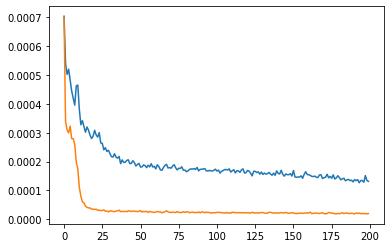

In [15]:
model_cases_loss = model_cases.history.history['loss']
model_deaths_loss = model_deaths.history.history['loss']
plt.plot(range(len(model_cases_loss)),model_cases_loss)
plt.plot(range(len(model_deaths_loss)),model_deaths_loss)

## Avaliação em dados de teste

In [16]:
# Agora vamos calcular as previsões do model_cases para as próximas observações

test_predictions_cases = []

first_eval_batch = Y_train[-n_input_cases:,[0]]
current_batch = first_eval_batch.reshape((1, n_input_cases, n_features))

for i in range(len(test)):
    current_batch = np.append(current_batch[:,1:,:],[[Y_test[i,[0]]]],axis=1)
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model_cases.predict(current_batch)[0]
    
    # predição
    test_predictions_cases.append(current_pred) 
    

In [17]:
# Agora vamos calcular as previsões do model_deaths para as próximas observações

test_predictions_deaths = []

first_eval_batch = Y_train[-n_input_deaths:,[1]]
current_batch = first_eval_batch.reshape((1, n_input_deaths, n_features))

for i in range(len(test)):
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model_deaths.predict(current_batch)[0]
    
    # predição
    test_predictions_deaths.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Retorno da normalização e comparação das previsões

In [18]:
# Possivelmente encontraremos warnings aqui
df['new_deaths2'] = population*df['new_deaths']/10000
test['Predictions_with_cases'] = np.concatenate((Y_test[:,[0]], test_predictions_cases),axis=1)[:,[1]]
test['Predictions_with_deaths'] = np.concatenate((Y_test[:,[0]], test_predictions_deaths),axis=1)[:,[1]]

test['new_deaths2'] = population*test['new_deaths']/10000
test['Predictions_with_cases2'] = population*test['Predictions_with_cases']/10000
test['Predictions_with_deaths2'] = population*test['Predictions_with_deaths']/10000

<ipython-input-18-94193b7a3f64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions_with_cases'] = np.concatenate((Y_test[:,[0]], test_predictions_cases),axis=1)[:,[1]]
<ipython-input-18-94193b7a3f64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions_with_deaths'] = np.concatenate((Y_test[:,[0]], test_predictions_deaths),axis=1)[:,[1]]
<ipython-input-18-94193b7a3f64>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

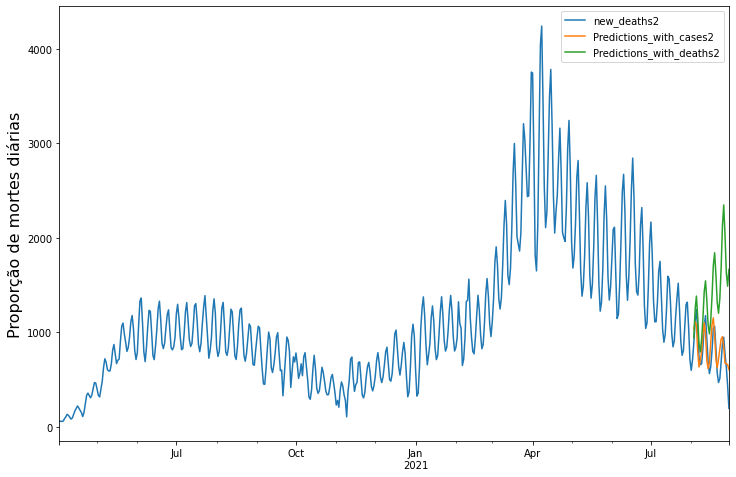

In [19]:
ax = df['new_deaths2'].plot(figsize=(12,8))
ax.set_ylabel('Proporção de mortes diárias', fontsize=16) 
test['Predictions_with_cases2'].plot(ax=ax)
test['Predictions_with_deaths2'].plot(ax=ax)
ax.legend()

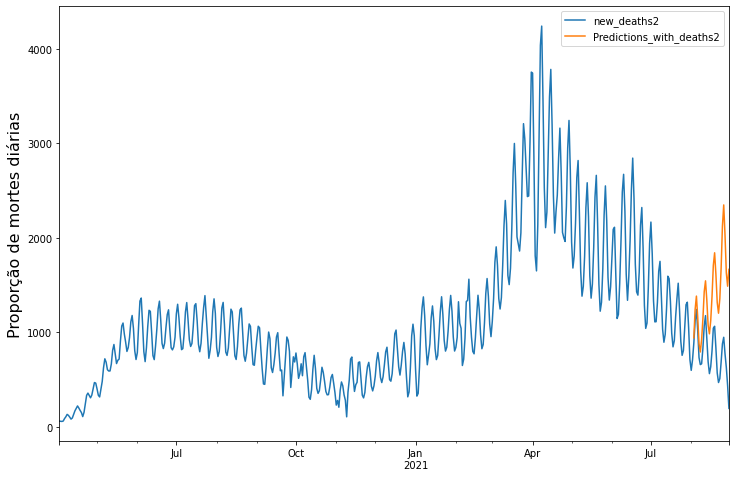

In [20]:
ax = df['new_deaths2'].plot(figsize=(12,8))
ax.set_ylabel('Proporção de mortes diárias', fontsize=16) 
test['Predictions_with_deaths2'].plot(ax=ax)
ax.legend()

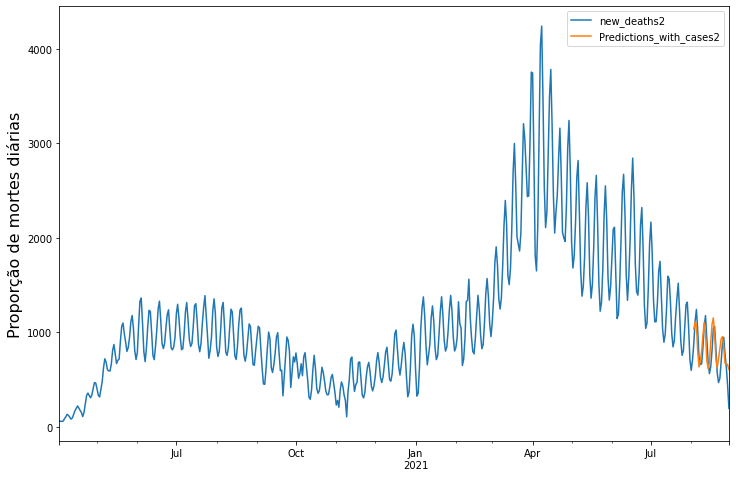

In [21]:
ax = df['new_deaths2'].plot(figsize=(12,8))
ax.set_ylabel('Proporção de mortes diárias', fontsize=16) 
test['Predictions_with_cases2'].plot(ax=ax)
ax.legend()

## Erro relativo

In [22]:
relative_errors = pd.DataFrame()
relative_errors['Predictions_with_deaths'] = round(100*np.abs(test['Predictions_with_deaths2']-test['new_deaths2'])/
                                                   test['new_deaths2'],2)
relative_errors['Predictions_with_cases'] = round(100*np.abs(test['Predictions_with_cases2']-test['new_deaths2'])/
                                                   test['new_deaths2'],2)
relative_errors

Predictions_with_deaths  Predictions_with_cases
2021-08-03                     6.36                   16.97
2021-08-04                    11.05                    0.43
2021-08-05                    11.39                   13.36
2021-08-06                    13.95                   21.67
2021-08-07                    19.95                   13.64
2021-08-08                    20.20                    6.43
2021-08-09                    38.60                   19.40
2021-08-10                    37.58                   16.17
2021-08-11                    33.82                    3.25
2021-08-12                    31.26                   16.42
2021-08-13                    43.27                   24.76
2021-08-14                    55.97                   10.63
2021-08-15                    74.68                   20.95
2021-08-16                    76.50                   40.51
2021-08-17                    71.63                   34.85
2021-08-18                    63.57                   10.48
2021-08-19                    73.02                    8.63
2021-08-20                    93.88                   13.63
2021-08-21                   130.38                    9.49
2021-08-22                   156.04                   53.55
2021-08-23                   165.26                   61.13
2021-08-24                   144.95                   35.57
2021-08-25                   141.75                    8.70
2021-08-26                   147.63                   10.94
2021-08-27                   162.17                   12.86
2021-08-28                   158.98                    6.17
2021-08-29                   240.50                   50.97
2021-08-30                   750.75                  209.38

In [23]:
# Erro relativo médio
relative_errors.mean()

Predictions_with_deaths    106.253214
Predictions_with_cases      26.819286
dtype: float64